# LogSumExp Smooth Approximation for $C_{1a}$

Replace the non-smooth objective $\max_k c_k$ with the smooth surrogate:
$$\mathrm{LSE}_\beta(c) = \frac{1}{\beta} \log \sum_k \exp(\beta \, c_k)$$

**Properties:**
- $\max_k c_k \le \mathrm{LSE}_\beta(c) \le \max_k c_k + \frac{\log n}{\beta}$
- Gradient: $\nabla_{c_k} \mathrm{LSE}_\beta = \mathrm{softmax}(\beta \, c)_k$ — distributes gradient across all near-peak positions
- Addresses peak-locking (bottleneck S4) by smoothing the $\arg\max$ discontinuity

**Strategy:** $\beta$-continuation — start with small $\beta$ (smooth landscape), gradually increase toward the true max.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import numba as nb
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from src.representations import StepFunction
from src.convolution import peak_autoconv_exact

print(f"Numba {nb.__version__}, NumPy {np.__version__}")
print(f"CPU cores available: {os.cpu_count()}")

Numba 0.63.1, NumPy 2.3.5
CPU cores available: 16


In [2]:
# === Numba-JIT compiled core functions ===
# All inner-loop math is compiled to machine code for ~50-100x speedup.

@nb.njit(cache=True)
def project_simplex_nb(x):
    """Project x onto the probability simplex."""
    n = len(x)
    u = np.sort(x)[::-1]
    cssv = np.cumsum(u) - 1.0
    rho = 0
    for i in range(n):
        if u[i] * (i + 1) > cssv[i]:
            rho = i
    tau = cssv[rho] / (rho + 1.0)
    out = np.empty(n)
    for i in range(n):
        out[i] = max(x[i] - tau, 0.0)
    return out


@nb.njit(cache=True)
def convolve_full(a, b):
    """Full convolution of two 1D arrays."""
    na, nb_ = len(a), len(b)
    nc = na + nb_ - 1
    c = np.zeros(nc)
    for i in range(na):
        for j in range(nb_):
            c[i + j] += a[i] * b[j]
    return c


@nb.njit(cache=True)
def autoconv_coeffs(x, P):
    """c_k = 2P * sum_{i+j=k} x_i x_j"""
    return convolve_full(x, x) * (2.0 * P)


@nb.njit(cache=True)
def logsumexp_nb(c, beta):
    """Numerically stable LogSumExp."""
    bc_max = -1e300
    for i in range(len(c)):
        v = beta * c[i]
        if v > bc_max:
            bc_max = v
    s = 0.0
    for i in range(len(c)):
        s += np.exp(beta * c[i] - bc_max)
    return bc_max / beta + np.log(s) / beta


@nb.njit(cache=True)
def softmax_nb(c, beta):
    """Softmax weights."""
    n = len(c)
    bc_max = -1e300
    for i in range(n):
        v = beta * c[i]
        if v > bc_max:
            bc_max = v
    e = np.empty(n)
    s = 0.0
    for i in range(n):
        e[i] = np.exp(beta * c[i] - bc_max)
        s += e[i]
    for i in range(n):
        e[i] /= s
    return e


@nb.njit(cache=True)
def lse_obj_nb(x, P, beta):
    c = autoconv_coeffs(x, P)
    return logsumexp_nb(c, beta)


@nb.njit(cache=True)
def lse_grad_nb(x, P, beta):
    """Gradient of LSE_beta(c(x)) w.r.t. x.
    g_i = 2*(2P) * sum_k w_k * x_{k-i}
    """
    c = autoconv_coeffs(x, P)
    w = softmax_nb(c, beta)
    n = len(x)
    n_c = len(c)
    g = np.zeros(n)
    for i in range(n):
        s = 0.0
        for k in range(n_c):
            j = k - i
            if 0 <= j < n:
                s += w[k] * x[j]
        g[i] = s
    scale = 2.0 * (2.0 * P)
    for i in range(n):
        g[i] *= scale
    return g


@nb.njit(cache=True)
def armijo_step_nb(x, g, P, beta, alpha_init, rho=0.5, c1=1e-4, max_bt=30):
    """Armijo backtracking line search."""
    fval = lse_obj_nb(x, P, beta)
    alpha = alpha_init
    x_new = np.empty_like(x)
    for _ in range(max_bt):
        for i in range(len(x)):
            x_new[i] = x[i] - alpha * g[i]
        x_new = project_simplex_nb(x_new)
        fval_new = lse_obj_nb(x_new, P, beta)
        descent = 0.0
        for i in range(len(x)):
            descent += g[i] * (x[i] - x_new[i])
        if fval_new <= fval - c1 * descent:
            return x_new, fval_new, alpha
        alpha *= rho
    return x_new, fval_new, alpha


# === Warm up JIT (first call compiles; subsequent calls are fast) ===
_x_warmup = np.ones(5) / 5.0
_ = project_simplex_nb(_x_warmup)
_ = autoconv_coeffs(_x_warmup, 5)
_ = lse_obj_nb(_x_warmup, 5, 10.0)
_ = lse_grad_nb(_x_warmup, 5, 10.0)
_ = armijo_step_nb(_x_warmup, np.ones(5), 5, 10.0, 0.1)

# Verify gradient with finite differences
np.random.seed(42)
P_test = 10
x_test = np.random.dirichlet(np.ones(P_test))
beta_test = 10.0
g_jit = lse_grad_nb(x_test, P_test, beta_test)
eps = 1e-7
g_fd = np.zeros(P_test)
for i in range(P_test):
    x_p = x_test.copy(); x_p[i] += eps
    x_m = x_test.copy(); x_m[i] -= eps
    g_fd[i] = (lse_obj_nb(x_p, P_test, beta_test) - lse_obj_nb(x_m, P_test, beta_test)) / (2 * eps)
print(f"JIT gradient vs finite diff: max error = {np.max(np.abs(g_jit - g_fd)):.2e}")
print("JIT compilation and verification complete.")

JIT gradient vs finite diff: max error = 2.00e-09
JIT compilation and verification complete.


In [3]:
# === JIT-compiled single-restart LSE Nesterov optimizer ===

@nb.njit(cache=True)
def _lse_single_restart(x_init, P, beta_schedule, n_iters_per_beta):
    """Run one full LSE Nesterov continuation from x_init. Returns (best_true_val, best_x)."""
    x = x_init.copy()
    best_true_val = 1e300
    best_x = x.copy()
    
    for stage in range(len(beta_schedule)):
        beta = beta_schedule[stage]
        y = x.copy()
        x_prev = x.copy()
        alpha_init = 0.1
        best_stage_val = 1e300
        best_stage_x = x.copy()
        no_improve = 0
        
        for t in range(n_iters_per_beta):
            g = lse_grad_nb(y, P, beta)
            x_new, fval_new, alpha_used = armijo_step_nb(y, g, P, beta, alpha_init)
            alpha_init = min(alpha_used * 2.0, 1.0)
            
            # Nesterov momentum
            momentum = t / (t + 3.0)
            n = len(x_new)
            y_new = np.empty(n)
            for i in range(n):
                y_new[i] = x_new[i] + momentum * (x_new[i] - x_prev[i])
            y_new = project_simplex_nb(y_new)
            
            x_prev = x_new.copy()
            x = x_new
            y = y_new
            
            true_val = np.max(autoconv_coeffs(x, P))
            if true_val < best_stage_val:
                best_stage_val = true_val
                best_stage_x = x.copy()
                no_improve = 0
            else:
                no_improve += 1
            
            if no_improve > 1000:
                break
        
        x = best_stage_x
    
    true_val = np.max(autoconv_coeffs(x, P))
    if true_val < best_true_val:
        best_true_val = true_val
        best_x = x.copy()
    
    return best_true_val, best_x


# Warm up the single-restart function
_bs = np.array([1.0, 10.0, 100.0])
_ = _lse_single_restart(np.ones(5) / 5.0, 5, _bs, 10)


def optimize_lse_parallel(P, beta_schedule, n_iters_per_beta=10000,
                           n_restarts=30, n_jobs=-1, verbose=True):
    """Parallel LSE Nesterov: each restart runs on a separate CPU core."""
    beta_arr = np.array(beta_schedule, dtype=np.float64)
    
    # Pre-generate all random initializations (Dirichlet)
    rng = np.random.default_rng()
    inits = [rng.dirichlet(np.ones(P)) for _ in range(n_restarts)]
    
    # Run restarts in parallel across cores
    results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(_lse_single_restart)(inits[i], P, beta_arr, n_iters_per_beta)
        for i in range(n_restarts)
    )
    
    # Find best across all restarts
    best_val = np.inf
    best_x = None
    for i, (val, x) in enumerate(results):
        if verbose and (i % 10 == 0 or val < best_val):
            tag = "  <-- best" if (best_x is None or val < best_val) else ""
            print(f"    Restart {i:>3}: {val:.6f}{tag}")
        if val < best_val:
            best_val = val
            best_x = x.copy()
    
    return best_val, best_x


print("Parallel LSE Nesterov optimizer defined.")

Parallel LSE Nesterov optimizer defined.


In [4]:
# === JIT-compiled Polyak subgradient ===

@nb.njit(cache=True)
def _polyak_single_restart(x_init, P, target, n_iters):
    """Run one Polyak subgradient trajectory. Returns (best_val, best_x)."""
    x = x_init.copy()
    n = len(x)
    best_val = 1e300
    best_x = x.copy()
    
    for t in range(n_iters):
        c = autoconv_coeffs(x, P)
        fval = np.max(c)
        if fval < best_val:
            best_val = fval
            best_x = x.copy()
        
        # Find argmax
        k_star = 0
        for k in range(len(c)):
            if c[k] > c[k_star]:
                k_star = k
        
        # Subgradient
        g = np.zeros(n)
        for i in range(n):
            j = k_star - i
            if 0 <= j < n:
                g[i] = 2.0 * (2.0 * P) * x[j]
        
        gnorm2 = 0.0
        for i in range(n):
            gnorm2 += g[i] * g[i]
        if gnorm2 < 1e-20:
            break
        
        step = (fval - target) / gnorm2
        if step < 0.0:
            step = 1e-4 / (1.0 + t)
        
        for i in range(n):
            x[i] = x[i] - step * g[i]
        x = project_simplex_nb(x)
    
    return best_val, best_x


# Warm up
_ = _polyak_single_restart(np.ones(5) / 5.0, 5, 1.5, 10)


def polyak_parallel(P, n_iters=100000, n_restarts=30,
                    targets=(1.51, 1.505, 1.50, 1.495, 1.49, 1.48),
                    n_jobs=-1, verbose=True):
    """Parallel Polyak subgradient across all (target, restart) pairs."""
    rng = np.random.default_rng()
    
    # Build all (init, target) pairs
    tasks = []
    for target in targets:
        for _ in range(n_restarts):
            tasks.append((rng.dirichlet(np.ones(P)), target))
    
    results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(_polyak_single_restart)(init, P, target, n_iters)
        for init, target in tasks
    )
    
    best_val = np.inf
    best_x = None
    for val, x in results:
        if val < best_val:
            best_val = val
            best_x = x.copy()
    
    if verbose:
        print(f"    Best across {len(tasks)} runs: {best_val:.6f}")
    
    return best_val, best_x


print("Parallel Polyak optimizer defined.")

Parallel Polyak optimizer defined.


In [5]:
# === Run comparison (JIT + parallel) ===

import time

P_values = [10, 20, 30, 50, 75, 100, 150, 200]
beta_schedule = [1, 2, 4, 8, 15, 30, 60, 100, 150, 250, 400, 600, 1000, 1500, 2000]

results = {}

for P in P_values:
    print(f"\n{'='*60}")
    print(f"P = {P}")
    print(f"{'='*60}")
    
    edges = np.linspace(-0.25, 0.25, P + 1)
    bin_width = 0.5 / P
    
    # LSE Nesterov (30 restarts, parallel)
    t0 = time.time()
    print(f"  LSE Nesterov (30 restarts, 15 stages, 10k iters/stage):")
    val_lse, x_lse = optimize_lse_parallel(
        P, beta_schedule, n_iters_per_beta=10000, n_restarts=30
    )
    sf_lse = StepFunction.from_heights(edges, x_lse / bin_width)
    exact_lse = peak_autoconv_exact(sf_lse)
    dt_lse = time.time() - t0
    print(f"  => LSE exact = {exact_lse:.6f}  ({dt_lse:.1f}s)")
    
    # Polyak (180 runs, parallel)
    t0 = time.time()
    print(f"  Polyak (180 runs, 100k iters):")
    val_poly, x_poly = polyak_parallel(P, n_iters=100000, n_restarts=30)
    sf_poly = StepFunction.from_heights(edges, x_poly / bin_width)
    exact_poly = peak_autoconv_exact(sf_poly)
    dt_poly = time.time() - t0
    print(f"  => Polyak exact = {exact_poly:.6f}  ({dt_poly:.1f}s)")
    
    delta = exact_lse - exact_poly
    winner = "LSE" if delta < 0 else "Polyak" if delta > 0 else "Tie"
    print(f"  >> Winner: {winner} (delta = {delta:+.6f})")
    
    results[P] = {
        'lse': (exact_lse, x_lse),
        'polyak': (exact_poly, x_poly),
    }


P = 10
  LSE Nesterov (30 restarts, 15 stages, 10k iters/stage):
    Restart   0: 1.579151  <-- best
    Restart   1: 1.566445  <-- best
    Restart   2: 1.566445  <-- best
    Restart  10: 1.596272
    Restart  20: 1.566450
  => LSE exact = 1.566445  (14.3s)
  Polyak (180 runs, 100k iters):
    Best across 180 runs: 1.569110
  => Polyak exact = 1.569110  (5.5s)
  >> Winner: LSE (delta = -0.002665)

P = 20
  LSE Nesterov (30 restarts, 15 stages, 10k iters/stage):
    Restart   0: 1.541075  <-- best
    Restart   8: 1.534157  <-- best
    Restart  10: 1.552187
    Restart  20: 1.547315
    Restart  27: 1.534157  <-- best
  => LSE exact = 1.534157  (1.0s)
  Polyak (180 runs, 100k iters):
    Best across 180 runs: 1.537814
  => Polyak exact = 1.537814  (4.8s)
  >> Winner: LSE (delta = -0.003657)

P = 30
  LSE Nesterov (30 restarts, 15 stages, 10k iters/stage):
    Restart   0: 1.533229  <-- best
    Restart   1: 1.532741  <-- best
    Restart   2: 1.532684  <-- best
    Restart   9: 1.53

In [6]:
# === Results table ===

print(f"{'P':>5} | {'LSE (exact)':>14} | {'Polyak (exact)':>14} | {'Delta':>10} | {'Winner':>8}")
print('-' * 62)
for P in P_values:
    r = results[P]
    v_lse = r['lse'][0]
    v_poly = r['polyak'][0]
    delta = v_lse - v_poly
    winner = "LSE" if delta < 0 else "Polyak" if delta > 0 else "Tie"
    print(f"{P:>5} | {v_lse:>14.6f} | {v_poly:>14.6f} | {delta:>+10.6f} | {winner:>8}")

print(f"\nBest known upper bound: 1.5029")

    P |    LSE (exact) | Polyak (exact) |      Delta |   Winner
--------------------------------------------------------------
   10 |       1.566445 |       1.569110 |  -0.002665 |      LSE
   20 |       1.534157 |       1.537814 |  -0.003657 |      LSE
   30 |       1.524704 |       1.532157 |  -0.007453 |      LSE
   50 |       1.521646 |       1.524243 |  -0.002598 |      LSE
   75 |       1.517313 |       1.520272 |  -0.002959 |      LSE
  100 |       1.513841 |       1.520211 |  -0.006370 |      LSE
  150 |       1.511188 |       1.516242 |  -0.005054 |      LSE
  200 |       1.512395 |       1.519926 |  -0.007531 |      LSE

Best known upper bound: 1.5029


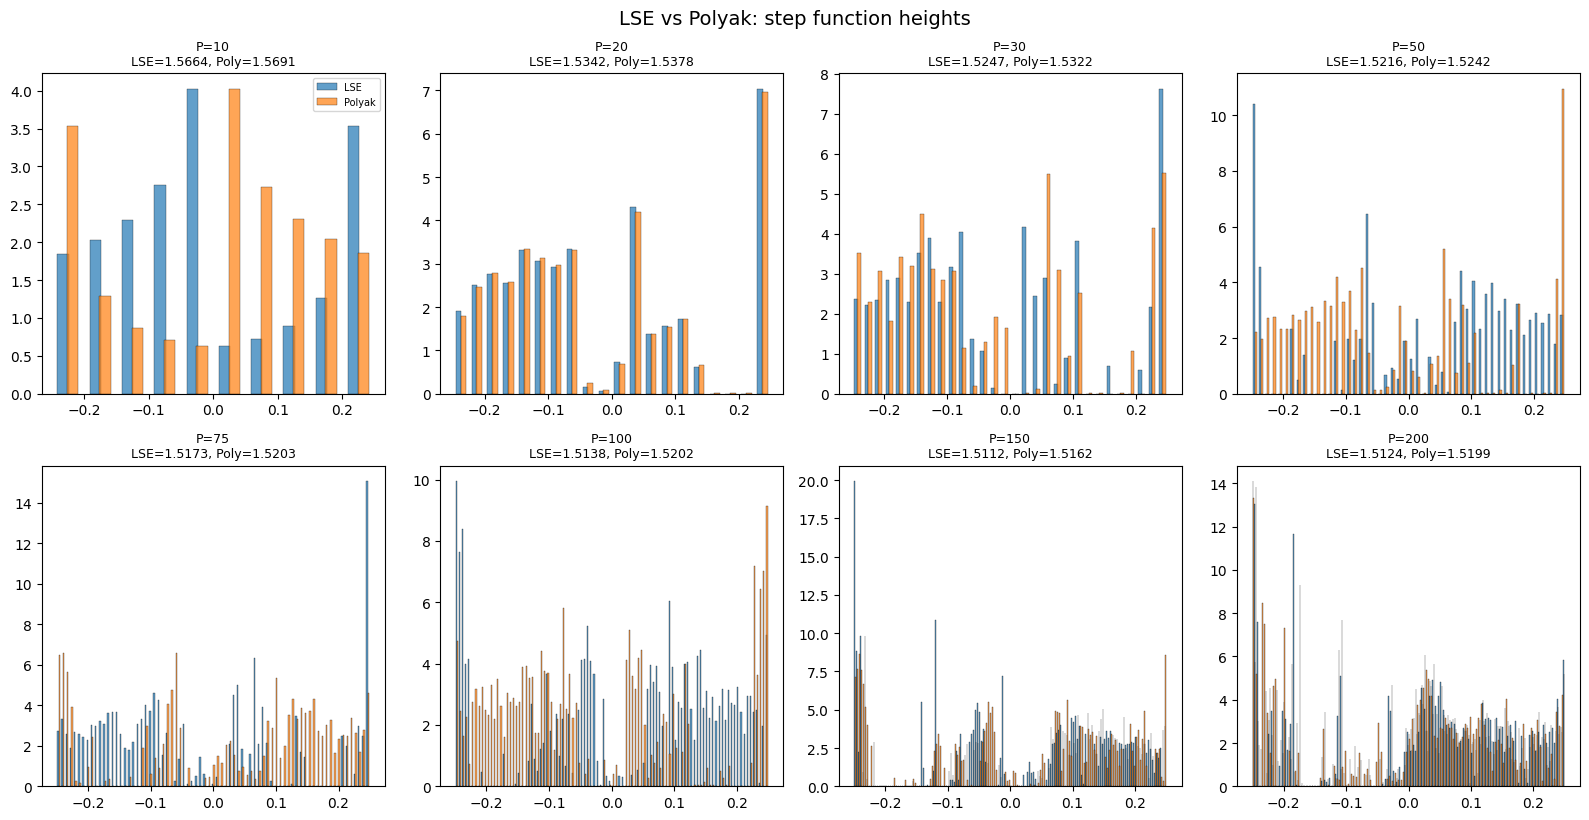

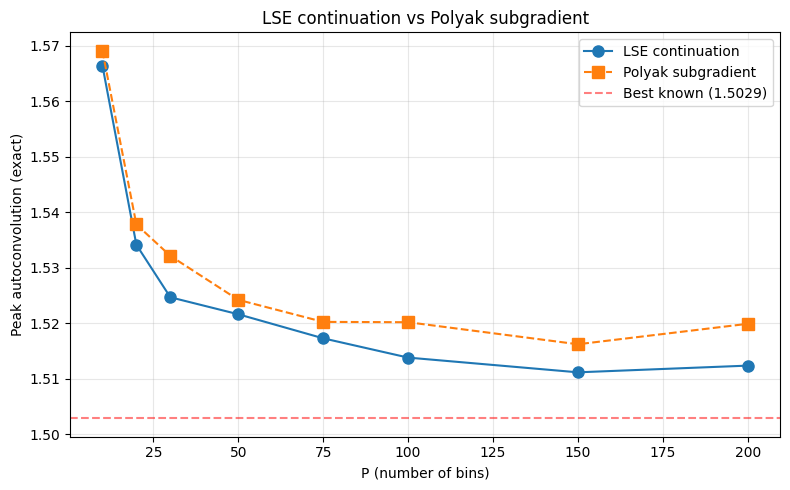

In [7]:
# === Visualization ===

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, P in enumerate(P_values):
    ax = axes[idx]
    edges = np.linspace(-0.25, 0.25, P + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    bin_width = 0.5 / P
    
    x_lse = results[P]['lse'][1]
    x_poly = results[P]['polyak'][1]
    
    ax.bar(centers - bin_width*0.15, x_lse / bin_width, width=bin_width*0.35,
           alpha=0.7, label='LSE', color='C0', edgecolor='k', linewidth=0.3)
    ax.bar(centers + bin_width*0.15, x_poly / bin_width, width=bin_width*0.35,
           alpha=0.7, label='Polyak', color='C1', edgecolor='k', linewidth=0.3)
    
    v_lse = results[P]['lse'][0]
    v_poly = results[P]['polyak'][0]
    ax.set_title(f'P={P}\nLSE={v_lse:.4f}, Poly={v_poly:.4f}', fontsize=9)
    if idx == 0:
        ax.legend(fontsize=7)

plt.tight_layout()
plt.suptitle('LSE vs Polyak: step function heights', y=1.02, fontsize=14)
plt.savefig('logsumexp_vs_polyak_heights.png', dpi=150, bbox_inches='tight')
plt.show()

# Convergence comparison
fig, ax = plt.subplots(figsize=(8, 5))
Ps = sorted(results.keys())
lse_vals = [results[P]['lse'][0] for P in Ps]
poly_vals = [results[P]['polyak'][0] for P in Ps]

ax.plot(Ps, lse_vals, 'o-', label='LSE continuation', markersize=8)
ax.plot(Ps, poly_vals, 's--', label='Polyak subgradient', markersize=8)
ax.axhline(1.5029, color='r', linestyle='--', alpha=0.5, label='Best known (1.5029)')
ax.set_xlabel('P (number of bins)')
ax.set_ylabel('Peak autoconvolution (exact)')
ax.set_title('LSE continuation vs Polyak subgradient')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('logsumexp_vs_polyak_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# === Ablation: beta schedule (parallel, JIT) ===

P_abl = 50
schedules = {
    'aggressive': np.array([1., 10., 100., 1000.]),
    'moderate': np.array([1., 2., 5., 10., 20., 50., 100., 200., 500., 1000.]),
    'fine_15': np.array([1., 2., 4., 8., 15., 30., 60., 100., 150., 250., 400., 600., 1000., 1500., 2000.]),
    'gentle': np.array([1., 1.5, 2., 3., 5., 7., 10., 15., 20., 30., 50., 75., 100., 150., 200., 300., 500., 750., 1000.]),
    'fixed_low': np.full(10, 10.0),
    'fixed_high': np.full(10, 1000.0),
}

print(f"Beta schedule ablation at P = {P_abl} (20 restarts each, parallel)")
print(f"{'Schedule':>15} | {'Stages':>6} | {'Exact obj':>12}")
print('-' * 42)

for name, sched in schedules.items():
    val, x = optimize_lse_parallel(
        P_abl, sched, n_iters_per_beta=8000, n_restarts=20, verbose=False
    )
    edges = np.linspace(-0.25, 0.25, P_abl + 1)
    bin_width = 0.5 / P_abl
    sf = StepFunction.from_heights(edges, x / bin_width)
    exact = peak_autoconv_exact(sf)
    print(f"{name:>15} | {len(sched):>6} | {exact:>12.6f}")

Beta schedule ablation at P = 50 (20 restarts each, parallel)
       Schedule | Stages |    Exact obj
------------------------------------------
     aggressive |      4 |     1.569054
       moderate |     10 |     1.523715
        fine_15 |     15 |     1.522239
         gentle |     19 |     1.520894
      fixed_low |     10 |     1.572650
     fixed_high |     10 |     1.547495


In [9]:
# === JIT-compiled hybrid: LSE continuation -> adaptive Polyak polish ===

@nb.njit(cache=True)
def _polyak_polish_nb(x_init, P, n_iters):
    """Adaptive Polyak polish: target = best_val - shrinking_offset."""
    x = x_init.copy()
    n = len(x)
    best_val = np.max(autoconv_coeffs(x, P))
    best_x = x.copy()
    
    for t in range(n_iters):
        c = autoconv_coeffs(x, P)
        fval = np.max(c)
        if fval < best_val:
            best_val = fval
            best_x = x.copy()
        
        offset = 0.01 / (1.0 + t * 1e-4)
        target = best_val - offset
        
        k_star = 0
        for k in range(len(c)):
            if c[k] > c[k_star]:
                k_star = k
        
        g = np.zeros(n)
        for i in range(n):
            j = k_star - i
            if 0 <= j < n:
                g[i] = 2.0 * (2.0 * P) * x[j]
        
        gnorm2 = 0.0
        for i in range(n):
            gnorm2 += g[i] * g[i]
        if gnorm2 < 1e-20:
            break
        
        step = (fval - target) / gnorm2
        if step < 0.0:
            step = 1e-5 / (1.0 + t * 1e-4)
        
        for i in range(n):
            x[i] = x[i] - step * g[i]
        x = project_simplex_nb(x)
    
    return best_val, best_x


@nb.njit(cache=True)
def _hybrid_single_restart(x_init, P, beta_schedule, n_iters_lse, n_iters_polyak):
    """One restart: LSE Nesterov continuation -> adaptive Polyak polish."""
    x = x_init.copy()
    
    # Phase 1: LSE continuation
    for stage in range(len(beta_schedule)):
        beta = beta_schedule[stage]
        y = x.copy()
        x_prev = x.copy()
        alpha_init = 0.1
        best_stage_val = 1e300
        best_stage_x = x.copy()
        no_improve = 0
        
        for t in range(n_iters_lse):
            g = lse_grad_nb(y, P, beta)
            x_new, fval_new, alpha_used = armijo_step_nb(y, g, P, beta, alpha_init)
            alpha_init = min(alpha_used * 2.0, 1.0)
            
            momentum = t / (t + 3.0)
            n = len(x_new)
            y_new = np.empty(n)
            for i in range(n):
                y_new[i] = x_new[i] + momentum * (x_new[i] - x_prev[i])
            y_new = project_simplex_nb(y_new)
            
            x_prev = x_new.copy()
            x = x_new
            y = y_new
            
            tv = np.max(autoconv_coeffs(x, P))
            if tv < best_stage_val:
                best_stage_val = tv
                best_stage_x = x.copy()
                no_improve = 0
            else:
                no_improve += 1
            if no_improve > 800:
                break
        
        x = best_stage_x
    
    lse_val = np.max(autoconv_coeffs(x, P))
    
    # Phase 2: adaptive Polyak polish
    polished_val, polished_x = _polyak_polish_nb(x, P, n_iters_polyak)
    
    return lse_val, polished_val, polished_x


# Warm up
_bs = np.array([1.0, 10.0])
_ = _polyak_polish_nb(np.ones(5) / 5.0, 5, 10)
_ = _hybrid_single_restart(np.ones(5) / 5.0, 5, _bs, 10, 10)


def hybrid_parallel(P, beta_schedule, n_iters_lse=10000,
                     n_iters_polyak=100000, n_restarts=30, n_jobs=-1, verbose=True):
    """Parallel hybrid: LSE basin-finding + adaptive Polyak polishing."""
    beta_arr = np.array(beta_schedule, dtype=np.float64)
    rng = np.random.default_rng()
    inits = [rng.dirichlet(np.ones(P)) for _ in range(n_restarts)]
    
    results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(_hybrid_single_restart)(inits[i], P, beta_arr, n_iters_lse, n_iters_polyak)
        for i in range(n_restarts)
    )
    
    best_val = np.inf
    best_x = None
    for i, (lse_v, pol_v, x) in enumerate(results):
        if verbose and (i % 10 == 0 or pol_v < best_val):
            tag = "  <-- best" if (best_x is None or pol_v < best_val) else ""
            print(f"    Restart {i:>3}: LSE={lse_v:.6f} -> polished={pol_v:.6f}{tag}")
        if pol_v < best_val:
            best_val = pol_v
            best_x = x.copy()
    
    return best_val, best_x


print("Parallel hybrid optimizer defined.")

Parallel hybrid optimizer defined.


In [10]:
# === Run all three methods head-to-head (heavy compute, parallel) ===

P_values_hybrid = [20, 50, 100, 200]
beta_sched = [1, 2, 4, 8, 15, 30, 60, 100, 150, 250, 400, 600, 1000, 1500, 2000]

results_hybrid = {}

for P in P_values_hybrid:
    print(f"\n{'='*60}")
    print(f"P = {P}")
    print(f"{'='*60}")
    edges = np.linspace(-0.25, 0.25, P + 1)
    bin_width = 0.5 / P
    
    # Hybrid (30 restarts, LSE -> adaptive Polyak, parallel)
    t0 = time.time()
    print(f"  Hybrid (30 restarts, parallel):")
    val_hyb, x_hyb = hybrid_parallel(
        P, beta_sched, n_iters_lse=10000, n_iters_polyak=100000, n_restarts=30
    )
    sf_hyb = StepFunction.from_heights(edges, x_hyb / bin_width)
    exact_hyb = peak_autoconv_exact(sf_hyb)
    dt = time.time() - t0
    print(f"  => Hybrid exact = {exact_hyb:.6f}  ({dt:.1f}s)")
    
    exact_lse = results.get(P, {}).get('lse', (None,))[0]
    exact_poly = results.get(P, {}).get('polyak', (None,))[0]
    
    results_hybrid[P] = {
        'hybrid': exact_hyb,
        'lse_only': exact_lse,
        'polyak_only': exact_poly,
    }

# === Final comparison table ===
print(f"\n\n{'='*72}")
print(f"FINAL RESULTS")
print(f"{'='*72}")
print(f"{'P':>5} | {'Hybrid':>12} | {'LSE only':>12} | {'Polyak only':>12} | {'Best known':>12}")
print('-' * 68)
for P in P_values_hybrid:
    r = results_hybrid[P]
    hyb_s = f"{r['hybrid']:>12.6f}" if r['hybrid'] is not None else f"{'N/A':>12}"
    lse_s = f"{r['lse_only']:>12.6f}" if r['lse_only'] is not None else f"{'N/A':>12}"
    pol_s = f"{r['polyak_only']:>12.6f}" if r['polyak_only'] is not None else f"{'N/A':>12}"
    print(f"{P:>5} | {hyb_s} | {lse_s} | {pol_s} | {1.5029:>12.4f}")


P = 20
  Hybrid (30 restarts, parallel):
    Restart   0: LSE=1.545160 -> polished=1.545072  <-- best
    Restart   5: LSE=1.543067 -> polished=1.542822  <-- best
    Restart   7: LSE=1.541759 -> polished=1.541469  <-- best
    Restart  10: LSE=1.548476 -> polished=1.548381
    Restart  12: LSE=1.540864 -> polished=1.540680  <-- best
    Restart  20: LSE=1.540374 -> polished=1.540243  <-- best
  => Hybrid exact = 1.540243  (5.5s)

P = 50
  Hybrid (30 restarts, parallel):
    Restart   0: LSE=1.529241 -> polished=1.528820  <-- best
    Restart   1: LSE=1.528368 -> polished=1.528074  <-- best
    Restart   2: LSE=1.526282 -> polished=1.526059  <-- best
    Restart   4: LSE=1.525431 -> polished=1.525072  <-- best
    Restart   8: LSE=1.524951 -> polished=1.524703  <-- best
    Restart  10: LSE=1.524704 -> polished=1.524478  <-- best
    Restart  12: LSE=1.523409 -> polished=1.523139  <-- best
    Restart  16: LSE=1.521993 -> polished=1.521775  <-- best
    Restart  20: LSE=1.532642 -> po